In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from keras import datasets
from keras.utils import to_categorical

offset = 0.5
multiplier = 255

npz_x = np.load('/content/gdrive/My Drive/Blender_Datasets/inputs_smaller.npz')
npz_y = np.load('/content/gdrive/My Drive/Blender_Datasets/outputs_smaller.npz')

In [0]:
npz_size = len(npz_x)
test_size = int(npz_size * 0.1)

input_shape = npz_x["arr_0"].shape
output_shape = npz_y["arr_0"].shape

def show_images(images, labels=None, start=0, columns=3, show_num=6, size=(20, 12.5), gamma=2.2):
  
    plt.figure(figsize=size)
    
    show_num = min(len(images), show_num)
    
    for i in range(start, start + show_num):
        ploti = i - start
        plt.subplot(show_num / columns + 1, columns, ploti + 1)
        
        if labels is not None:
            plt.title(labels[i])
        
        plt.grid(None)
        plt.axis('off')
        
        plt.imshow(np.power(np.clip(images[i].astype(np.float32), 0, 1), 1/2.2), vmin=0, vmax=1, cmap='gray')

    plt.show()

def get_batch(batch_size=16, is_train=True, ignore=-3):
  if is_train:
    idx = np.random.permutation(npz_size - test_size)[:batch_size]
  else:
    idx = np.random.permutation(np.arange(start=npz_size - test_size, stop=npz_size))[:batch_size]
  
  xarr = []
  yarr = []
  
  for i in idx:
    iname = "arr_" + str(i)
    
    x = npz_x[iname] / multiplier - offset
    y = npz_y[iname] / multiplier - offset
    
    if (ignore == 0):
      xarr.append(x)
    else:
      xarr.append(x[:, :, :ignore])
    yarr.append(y)
  
  xarr = np.array(xarr).astype(np.float16)
  yarr = np.array(yarr).astype(np.float16)
  
  return xarr, yarr, idx

def get_all(is_train=True, ignore=-3):
  if is_train:
    idx = np.arange(npz_size - test_size)[:batch_size]
  else:
    idx = np.arange(start=npz_size - test_size, stop=npz_size)
  
  xarr = []
  yarr = []
  
  for i in idx:
    iname = "arr_" + str(i)
    
    x = npz_x[iname] / multiplier - offset
    y = npz_y[iname] / multiplier - offset
    
    if (ignore == 0):
      xarr.append(x)
    else:
      xarr.append(x[:, :, :ignore])
    yarr.append(y)
  
  xarr = np.array(xarr).astype(np.float16)
  yarr = np.array(yarr).astype(np.float16)
  
  return xarr, yarr, idx

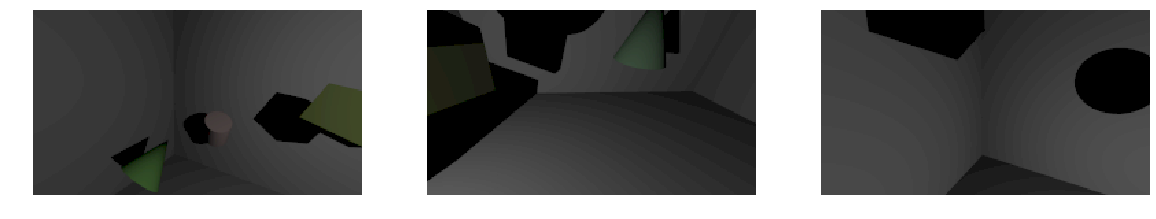

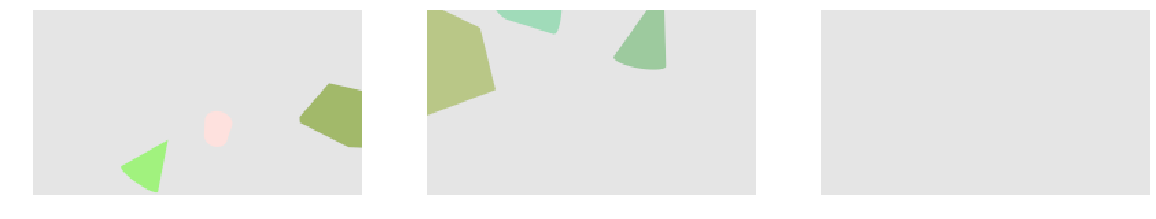

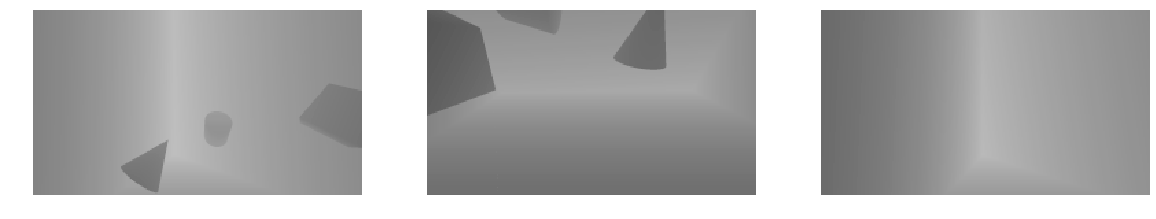

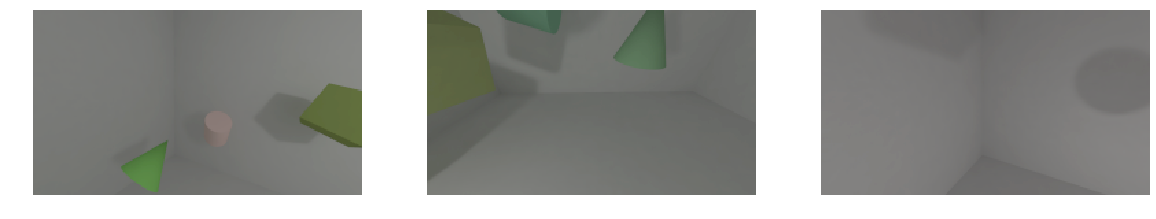

(3, 135, 240, 13)
(3, 135, 240, 3)


In [8]:
test_batch_x, test_batch_y, _ = get_batch(batch_size=3)
show_images(test_batch_x[:,:,:,:3] + offset)
show_images(test_batch_x[:,:,:,6:9] + offset)
show_images(np.concatenate((test_batch_x[:,:,:,12:13],test_batch_x[:,:,:,12:13],test_batch_x[:,:,:,12:13]), axis=-1) + offset)
show_images(test_batch_y + offset)
print(test_batch_x.shape)
print(test_batch_y.shape)

In [0]:
from keras.models import Model
from keras.models import Sequential

from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LeakyReLU, ELU
from keras.layers import MaxPool2D, AveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Cropping2D
from keras.layers import BatchNormalization
from keras.layers import Input, Flatten, Maximum, Add, Lambda, Reshape, Concatenate
from keras.layers import Dropout

from keras.regularizers import l2

from keras.losses import categorical_crossentropy, mean_squared_error, mean_absolute_error, binary_crossentropy, mse
from keras.optimizers import SGD
from keras.optimizers import Adam


def ED(input_shape, output_depth, inner_depth=3, restore_depth=3, highway_depth=64, regul=0.001, leakiness=0.1):
    
    inputs = Input(shape=[input_shape[0], input_shape[1], input_shape[2] - 3])
    
    x = inputs
    
    x = Conv2D(highway_depth, (3, 3), padding='same', kernel_regularizer=l2(regul), kernel_initializer='he_normal')(x)
    x = LeakyReLU(alpha=leakiness)(x)
    
    for i in range(inner_depth):
      x = Conv2D(highway_depth, (3, 3), padding='same', kernel_regularizer=l2(regul), kernel_initializer='he_normal')(x)
      x = LeakyReLU(alpha=leakiness)(x)
    
    x = Concatenate()([x, inputs])
    
    for i in range(restore_depth):
      x = Conv2D(highway_depth, (3, 3), padding='same', kernel_regularizer=l2(regul), kernel_initializer='he_normal')(x)
      x = LeakyReLU(alpha=leakiness)(x)
    
    x = Conv2D(3, (3, 3), padding='same', kernel_regularizer=l2(regul), kernel_initializer='he_normal')(x)
    
    outputs = x
    
    ed = Model(inputs, outputs, name='ed_conv')
    ed.summary()
    
    return ed
    

In [19]:
K.clear_session()
K.reset_uids()

model = ED(input_shape, output_shape[2], regul=0, leakiness=0.1)

loss=mean_squared_error

Model: "ed_conv"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 135, 240, 13) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 135, 240, 64) 7552        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 135, 240, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 135, 240, 64) 36928       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
optimizer = SGD(lr=0.1, clipvalue=0.01, momentum=0.9, decay=0.001, nesterov=True)
model.compile(optimizer=optimizer, loss=loss)

In [0]:
iters = 100000
showloss = 20
loss_preview_start = 10

iter_losses = []

for i in range(iters):
  x, y, _ = get_batch(32, ignore=-3)
  iter_loss = model.train_on_batch(x, y)
  iter_losses.append(iter_loss)
  
  if i % showloss == 0:
    print(str(i) + ", " + str(sum(iter_losses)/len(iter_losses)) )
    
    iter_losses = []
    continue
    
  if i < loss_preview_start:
    print(str(i) + ", " + str(iter_loss))
    

In [0]:
model.save('/content/gdrive/My Drive/Models/model_illumination_11_m5.hdf5')

In [0]:
model.load_weights('/content/gdrive/My Drive/Models/model_illumination_11_m5.hdf5')

In [16]:
all_test_x, all_test_y, all_test_idx = get_all(is_train=False)

test_x, test_y, test_idx = get_batch(3, is_train=False, ignore=-3)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.float32)
print(test_idx)

[913 942 921]


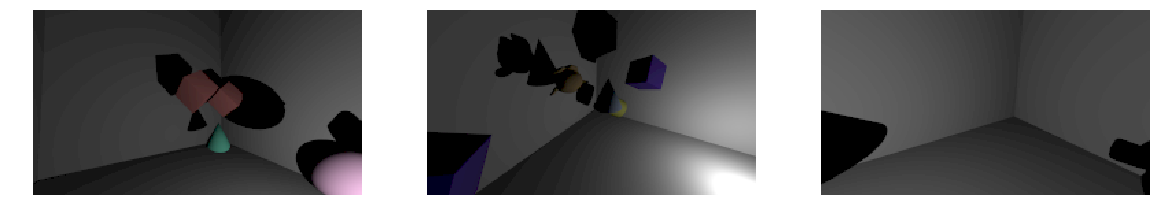

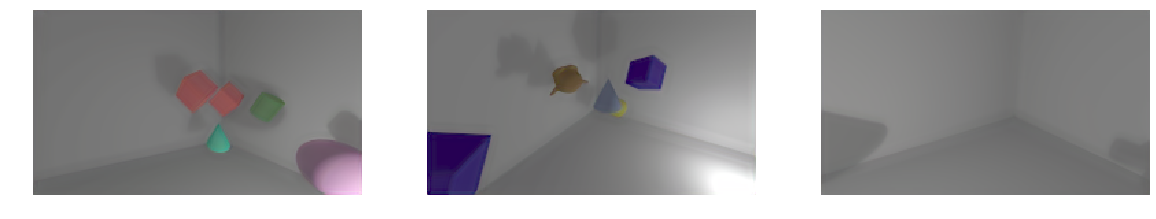

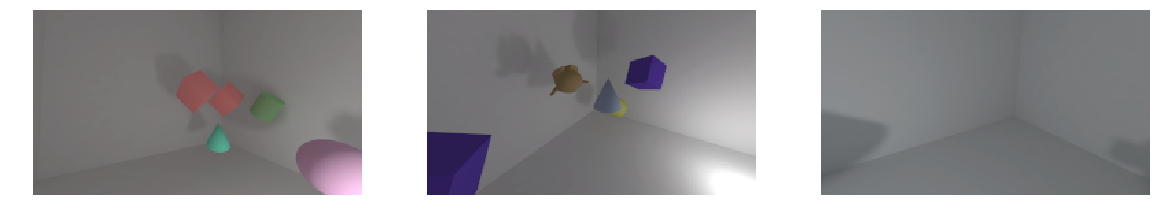

In [48]:
predict_x = model.predict(test_x)
show_images(test_x[:,:,:,0:3] + offset)
show_images(predict_x + offset)
show_images(test_y + offset)

In [37]:
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 1.0
    return 10 * math.log10(PIXEL_MAX / mse)

all_test_predict = model.predict(all_test_x)

predict_psnr = psnr(all_test_predict[:,:,:,:3], all_test_y[:,:,:,:3])
local_psnr = psnr(all_test_x[:,:,:,:3], all_test_y[:,:,:,:3])

print(local_psnr)
print(predict_psnr)

16.599307792919177
34.28741427049388
